In [13]:
import os, random, copy, json, requests
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib import patches, text
from PIL import Image
from collections import defaultdict
from itertools import chain

import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

device: cpu


# Load the Flickr8k dataset

## Option 1: Return Image with All Associated Captions

In this approach, for each index, __getitem__ returns the same image with all five captions. This means that during training, each image will be processed once per batch but will be associated with all its captions.

**Benefits:**

- This approach keeps all the context (captions) for an image together, which can be useful if the model or training strategy benefits from seeing all the descriptions of an image at once.
- It's efficient in terms of I/O since to load each image once per batch.

**Considerations:**

- The model and training loop need to handle batches where each item contains one image and multiple captions.
- This might require modifications in the way to compute the loss, as i'll be dealing with a batch of images and a batch of caption sets.

## Option 2: Return Image with One Caption at a Time

In this approach, __getitem__ randomly selects one of the captions to return with the image. Alternatively, I could cycle through the captions in a deterministic way.

**Benefits:**

- This method simplifies the training loop and loss calculation since each item in a batch is a standard image-caption pair.
- It aligns with standard practices for image-caption pair datasets.

**Considerations:**

- Each image will be loaded multiple times (once for each caption), which may be less efficient in terms of I/O.
- The model sees each caption independently and doesn't have the context of the other captions for the same image.


In [2]:
MAX_SEQ_LENGTH=20  # In reality the max length is 38

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

        # Add special tokens
        for token in ['<PAD>', '<SOS>', '<EOS>', '<UNK>']:
            self.add_word(token)
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions_list):
        for captions in captions_list:
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

    def lemma_to_tokens(self, lemma):
        tokens = nltk.word_tokenize(lemma.lower())
        token_ids = [self.word2idx['<SOS>']]  # Start with <SOS> token

        # Truncate the tokens to fit within the MAX_SEQ_LENGTH with <EOS>
        for token in tokens[:MAX_SEQ_LENGTH - 2]:  # Reserve space for <SOS> and <EOS>
            if token == '.':  # Stop if we see a period
                break
            elif token in self.word2idx:
                token_ids.append(self.word2idx[token])
            else:
                token_ids.append(self.word2idx['<UNK>'])  # Replace unknown words with <UNK>

        token_ids.append(self.word2idx['<EOS>'])  # End with <EOS> token

        # Pad the sequence to a fixed length
        return token_ids + [self.word2idx['<PAD>']] * (MAX_SEQ_LENGTH - len(token_ids))

    def tokens_to_lemma(self, tokens):
        words = []
        for token in tokens:
            word = self.idx2word[token]
            words.append(word)
        return ' '.join(words)
    
    

# Create a vocabulary object
vocab = Vocabulary()


class Flickr8kDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, split='train', transform=None):
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.split = split
        self.transform = transform
        self.image_paths = self.load_image_paths()
        self.annotations = self.load_annotations()

    def load_image_paths(self):
        image_paths = []
        with open(f'{self.annotation_folder}/Flickr_8k.{self.split}Images.txt', 'r') as f:
            lines = f.readlines()
            for l in lines:
              image_paths.append(l.strip())
        return image_paths

    def load_annotations(self):
        annotations = defaultdict(list)
        with open(f'{self.annotation_folder}/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split('\t')
                image_name, caption = parts[0].split('#')[0], parts[1]
                annotations[image_name].append(caption)
        return annotations

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        image_path = f'{self.image_folder}/{image_name}'
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        # Get captions for the current image
        captions = self.annotations[image_name]

        # select a random caption from the 5 captions for the current image
        caption = captions[random.randint(0, 4)]

        # Preprocess caption
        tokenized_caption = vocab.lemma_to_tokens(caption)

        # select a random caption from the 5 captions for the current image
        return {'image': image, 'caption': tokenized_caption}
    

In [3]:
image_folder = 'Flickr8k_Dataset'
annotation_folder = 'Flickr8k_text'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_folder, annotation_folder, split='train', transform=transform)
validation_dataset = Flickr8kDataset(image_folder, annotation_folder, split='dev', transform=transform)
test_dataset = Flickr8kDataset(image_folder, annotation_folder, split='test', transform=transform)

# CAN ADD THE TEST TO THE VALIDATION OR TRAINIING IN ORDER TO HAVE MORE DATA
#validation_dataset = validation_dataset + test_dataset

print(f"Train: {len(train_dataset)} imgs; Val: {len(validation_dataset)} imgs; Test: {len(test_dataset)} imgs")


Train: 6000 imgs; Val: 1000 imgs; Test: 1000 imgs


# Lemmatization & Vocabulary

In [4]:
# Download the WordNet resource for lemmatization
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/psaghelyi-
[nltk_data]     remote/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/psaghelyi-
[nltk_data]     remote/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:


# Build the vocabulary from the captions in the training dataset
vocab.build_vocabulary(train_dataset.annotations.values())

VOCAB_SIZE = len(vocab.word2idx)

# Print the size of the vocabulary
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 7705


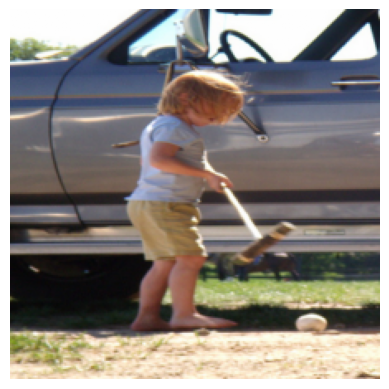

Image path: 2903617548_d3e38d7f88.jpg
- [1, 26, 24, 147, 9, 37, 38, 4, 4282, 3068, 32, 135, 893, 26, 219, 2, 0, 0, 0, 0]
- <SOS> the little boy is playing with a croquet hammer and ball beside the car <EOS> <PAD> <PAD> <PAD> <PAD>


In [6]:
def visualize_sample(dataset, i=0):
  sample = dataset[i]
  image, caption = sample['image'], sample['caption']

  # Convert PyTorch tensor to NumPy array and transpose the dimensions
  image_np = np.transpose(image.numpy(), (1, 2, 0))

  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

  lemma = vocab.tokens_to_lemma(caption)
  print(f"Image path: {dataset.image_paths[i]}")
  print(f"- {caption}")
  print(f"- {lemma}")

visualize_sample(train_dataset, 1)

**Define the DataSet Loaders**

In [7]:
BATCH_SIZE = 32

def custom_collate_fn(data):
    """
    Custom collate function to handle batches of images with multiple captions.
    `data` is a list of tuples with (image, captions).
    """
    images, all_captions = zip(*data)

    # Handle images - assuming they are already tensors of the same size
    images = torch.stack(images, 0)

    # Flatten the list of captions
    captions = [caption for captions_list in all_captions for caption in captions_list]

    # Pad the captions to the same length
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])

    return images, captions


# use this for the multi-caption option
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Encoder and Decoder Model Definition**:
   - Define CNN encoder (possibly using a pre-trained model like ResNet) and sequence-based decoder (RNN, LSTM, or Transformer).
   - Implement an attention mechanism in the decoder if desired.

In [8]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # Load a pre-trained ResNet model
        resnet = models.resnet50(weights='DEFAULT')
        # Remove the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        # Pass the image through the ResNet, excluding the last FC layer
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.embed(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        # replace <EOS> token for training with <PAD> token's tensor id
        for caption in captions:
            caption[caption == vocab.word2idx['<EOS>']] = vocab.word2idx['<PAD>']
        
        embeddings = self.embed(captions)

        #print(f"Caption tensor shape: {captions.shape}")  # Expected: [10, 20]
        #print(f"Embeddings shape (after embed layer): {embeddings.shape}")  # Expected: [10, 20, 256]

        # Assuming seq_length is 20 and embedding_size matches features
        embeddings = embeddings.view(-1, 20, embeddings.size(-1))

        # Expand features to match the sequence length of embeddings
        features_expanded = features.unsqueeze(1).expand(-1, 20, -1)

        # Debug prints to check the shapes (can be removed later)
        #print(f"Features expanded shape: {features_expanded.shape}")  # Expected: [10, 20, embed_size]
        #print(f"Embeddings shape: {embeddings.shape}")                # Expected: [10, 20, embed_size]
        
        #print("Embeddings NaN:", torch.isnan(embeddings).any())
        #print("Features NaN:", torch.isnan(features).any())

        # Concatenate along the last dimension (embedding dimension)
        combined = torch.cat((features_expanded, embeddings), 2)
        #print("Combined NaN:", torch.isnan(combined).any())
        #print("Max value in combined:", combined.max())
        #print("Min value in combined:", combined.min())
                
        lstm_params_before = sum(p.sum() for p in self.lstm.parameters())
        hiddens, (hidden_state, cell_state) = self.lstm(combined)
        lstm_params_after = sum(p.sum() for p in self.lstm.parameters())
        #print("LSTM params sum before:", lstm_params_before)
        #print("LSTM params sum after:", lstm_params_after)
        #print("Hidden state max:", hidden_state.max())
        #print("Cell state max:", cell_state.max())
        #print("Hiddens NaN:", torch.isnan(hiddens).any())

        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, max_len=20):
        """Generate captions for given image features using greedy search."""
        generated_caption = []
        states = None
        inputs = features.unsqueeze(1)

        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            generated_caption.append(predicted.item())
            inputs = self.embed(predicted).unsqueeze(1)

            if predicted == vocab.stoi["<EOS>"]:
                break

        return generated_caption
    
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)



In [9]:
embed_size = 256
hidden_size = 512
vocab_size = VOCAB_SIZE

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)
decoder._init_weights()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001)


**Training Loop**
  - Loss Function: Cross-Entropy Loss.
  - Optimizer: Let's do Adam (I have a slow machine and I found Adam to be faster than SGD)

In [10]:
def train(encoder, decoder, train_loader, optimizer, criterion, current_epoch, device):
    encoder.train()
    decoder.train()

    total_loss = 0

    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f'Epoch {current_epoch+1}')

    for data in progress_bar:
        images = data['image'].to(device)
        captions = torch.stack(data['captions'], dim=1).to(device)
        
        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate loss
        loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
        total_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(chain(encoder.parameters(), decoder.parameters()), max_norm=1.0)

        optimizer.step()

        # Update the progress bar description with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average loss over the epoch
    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{current_epoch + 1}] completed, Average Loss: {average_loss:.4f}')


In [11]:
def validate(encoder, decoder, val_loader, criterion):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        total_loss = 0
        for data in val_loader:
            images = data['image'].to(device)
            captions = torch.stack(data['caption'], dim=1).to(device)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions)

            # Calculate loss
            loss = criterion(outputs.view(-1, vocab_size), captions.reshape(-1))
            total_loss += loss.item()

        average_loss = total_loss / len(val_loader)
        print(f'Validation Loss: {average_loss:.4f}')


**Additional Considerations**
  - Adjusting Learning Rate: If you notice that the training or validation loss plateaus, consider implementing a learning rate scheduler to adjust the learning rate during training.
  - Early Stopping: To avoid overfitting, you can implement an early stopping mechanism. If the validation loss does not improve for a certain number of epochs, you can stop the training.
  - Tracking Training Progress: Optionally, you can track more metrics or add functionalities to visualize the training progress, like plotting the loss curves.
  - Testing the Model: After training, you can load the best model and run it on the test dataset to generate captions and calculate the BLEU score.

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                                Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [15]:
num_epochs = 10  
best_val_loss = float('inf')  # Initialize best validation loss as infinity
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Train and Validate
    train(encoder, decoder, train_loader, optimizer, criterion, epoch)
    val_loss = validate(encoder, decoder, validation_loader, criterion)
    early_stopping(val_loss)
    
    # Checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(encoder.state_dict(), 'encoder_best.pth')
        torch.save(decoder.state_dict(), 'decoder_best.pth')

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break


Epoch 1/10
----------
Loss value: nan


KeyboardInterrupt: 